# PyCUDA-图像处理-区域生长

In [1]:
import pycuda.autoinit
import pycuda.driver as cu
from pycuda import gpuarray as gpu
from pycuda.reduction import ReductionKernel
from pycuda.elementwise import ElementwiseKernel
import time
import numpy as np
from pycuda.compiler import SourceModule
import string
import cv2
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import  animation

In [2]:
def load_kernel_from_file(fname,kname):
    sources = None
    kernel = None
    with open(fname) as f:
        sources = f.read() # 通过str函数转换为unicode编码
        sm = SourceModule(str(sources))
        kernel = sm.get_function(kname)
    return kernel

def load_kernel_from_string(sources,kname):
    sm = SourceModule(str(sources))
    kernel = sm.get_function(kname)
    return kernel

In [3]:
findseeds_kernel = load_kernel_from_file('../../datas/cuda/17-region-grow.cu','findseeds_kernel')

In [4]:
fullgrow_kernel = load_kernel_from_file('../../datas/cuda/17-region-grow.cu','fullgrow_kernel')

In [5]:
src = cv2.cvtColor(cv2.imread('../../datas/f2.jpg'),cv2.COLOR_BGR2RGB)
gray = cv2.cvtColor(src,cv2.COLOR_RGB2GRAY)

In [6]:
image = src[:,:,0]
rows,cols = np.int32(image.shape)
im_region  = np.zeros((rows,cols),dtype=np.float64)
orig_im = np.array(image,dtype=np.float64) / 255.0
N = rows*cols

In [7]:
block = (32,32,1)
grid = (int(cols / block[0]),int(rows / block[1]),1)

In [8]:
findseeds_kernel(cu.In(orig_im),cu.Out(im_region),rows,cols,block=block,grid=grid)

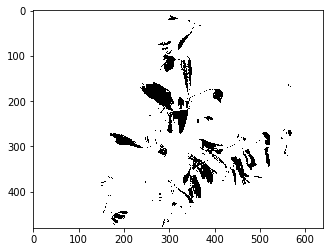

In [9]:
plt.imshow(im_region,'gray')

In [11]:
# while True:
d_region = gpu.to_gpu(im_region)
while True:
    d_conv_test = gpu.zeros(int(N), dtype=np.float64)
#     d_conv = gpu.to_gpu(d_conv_test)
#     print(im_region)
    fullgrow_kernel(cu.In(orig_im),d_region,d_conv_test,
                         np.int32(rows),np.int32(cols),block=block,grid=grid)
#     val = np.sum(d_conv.get())
#     print(val)
    if np.sum(d_conv_test.get()):
        break
    else:
        continue
    d_conv_test = gpu.zeros.fill(np.int32(0))

In [12]:
im_region = d_region.get()
print(im_region)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 1. 1. ... 1. 1. 0.]
 [0. 1. 1. ... 1. 1. 0.]
 ...
 [0. 1. 1. ... 1. 1. 0.]
 [0. 1. 1. ... 1. 1. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


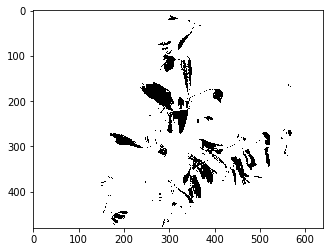

In [13]:
im_region = im_region.astype(np.uint8)
plt.imshow(im_region,'gray')